# Innitialize

In [1]:
import os
from google.colab import userdata
os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')
os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')
os.environ['GIT_TOKEN'] = userdata.get('GIT_TOKEN')

In [2]:
!git clone https://$GIT_TOKEN@$repo
!kaggle competitions download -c aml-competition
!unzip -o aml-competition.zip -d data
!git clone https://github.com/Mamiglia/challenge.git

Streaming output truncated to the last 5000 lines.
  inflating: data/train/train/Images/4945997009.jpg  
  inflating: data/train/train/Images/4946004444.jpg  
  inflating: data/train/train/Images/4946023775.jpg  
  inflating: data/train/train/Images/4946045875.jpg  
  inflating: data/train/train/Images/4946160196.jpg  
  inflating: data/train/train/Images/4946245832.jpg  
  inflating: data/train/train/Images/494625641.jpg  
  inflating: data/train/train/Images/4946401409.jpg  
  inflating: data/train/train/Images/4946431326.jpg  
  inflating: data/train/train/Images/4946877047.jpg  
  inflating: data/train/train/Images/4946968361.jpg  
  inflating: data/train/train/Images/4946977529.jpg  
  inflating: data/train/train/Images/4946986337.jpg  
  inflating: data/train/train/Images/4947072825.jpg  
  inflating: data/train/train/Images/4947153201.jpg  
  inflating: data/train/train/Images/4947321869.jpg  
  inflating: data/train/train/Images/4947854878.jpg  
  inflating: data/train/train/Im

In [3]:
from typing import List
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from pathlib import Path
from tqdm.auto import tqdm
import torch.nn.functional as F
import numpy as np
from enum import Enum
import math
import random
import matplotlib.pyplot as plt

In [4]:
from challenge.src.common import load_data, prepare_train_data, generate_submission
from challenge.src.eval import visualize_retrieval, evaluate_retrieval
from challenge.src.eval.metrics import recall_at_k, ndcg,mrr

In [5]:
%pip install optuna

In [6]:
import optuna

In [7]:
!pip install torchdiffeq

In [8]:
!git clone https://github.com/qihao067/CrossFlow.git

fatal: destination path 'CrossFlow' already exists and is not an empty directory.


In [9]:
def set_seed(seed=42):
    """Ensure deterministic reproducibility."""
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
set_seed()

In [10]:
WORKING_DIR = Path.cwd()

In [11]:
MODELS_DIR = Path("/").absolute()
MODEL_PATH = MODELS_DIR / "default.pth"

In [12]:
DATA_PATH = WORKING_DIR / "data"

In [13]:
EPOCHS = 20
BATCH_SIZE = 256
LR = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
sys.path.append(str(WORKING_DIR / "CrossFlow"))
from CrossFlow.diffusion.flow_matching import ClipLoss, SigLipLoss

# Actuall code

## Basic definitions

In [15]:
class Statistics():
  losses = []
  best_loss = float("inf")
  best_epoch_index = -1
  mse_losses = []
  cos_losses = []
  contrastive_losses = []

In [16]:
class DataKeeper():
  train_data = None
  train_loader = None
  val_loader = None
  train_dataset = None
  val_dataset = None
  val_caption_text = None
  val_text_embd = None
  val_img_file = None
  val_img_embd = None
  val_label = None
  def create_loaders(self, batch_size = BATCH_SIZE):
    self.train_loader = DataLoader(self.train_dataset, batch_size=batch_size, shuffle=True)
    self.val_loader = DataLoader(self.val_dataset, batch_size=batch_size)

In [17]:
def get_train_data(data_path=DATA_PATH, split_ratio = 0.8, batch_size = BATCH_SIZE):
  data_keeper = DataKeeper()
  data_keeper.train_data = load_data(data_path/"train/train/train.npz")
  X, y, label = prepare_train_data(data_keeper.train_data)
  DATASET_SIZE = len(X)
  train_size = int(DATASET_SIZE * split_ratio)
  TRAIN_SPLIT = torch.zeros(len(X), dtype=bool)
  TRAIN_SPLIT[:train_size] = True
  X_train, X_val = X[TRAIN_SPLIT], X[~TRAIN_SPLIT]
  y_train, y_val = y[TRAIN_SPLIT], y[~TRAIN_SPLIT]
  data_keeper.train_dataset = TensorDataset(X_train, y_train)
  data_keeper.val_dataset = TensorDataset(X_val, y_val)
  data_keeper.train_loader = DataLoader(data_keeper.train_dataset, batch_size=batch_size, shuffle=True)
  data_keeper.val_loader = DataLoader(data_keeper.val_dataset, batch_size=batch_size)
  img_VAL_SPLIT = label[~TRAIN_SPLIT].sum(dim=0) > 0
  data_keeper.val_caption_text = data_keeper.train_data['captions/text'][~TRAIN_SPLIT]
  data_keeper.val_text_embd = X_val
  data_keeper.img_VAL_SPLIT = label[~TRAIN_SPLIT].sum(dim=0) > 0
  data_keeper.val_img_file = data_keeper.train_data['images/names'][img_VAL_SPLIT]
  data_keeper.val_img_embd = torch.from_numpy(data_keeper.train_data['images/embeddings'][img_VAL_SPLIT])
  data_keeper.val_label = np.nonzero(data_keeper.train_data['captions/label'][~TRAIN_SPLIT][:,img_VAL_SPLIT])[1]
  return data_keeper


In [18]:
def save_model(model, path=MODEL_PATH, verbose=True):
  torch.save(model.state_dict(), path)
  print(f"Model saved to {path}")

In [19]:
def load_model(model, path=MODEL_PATH, verbose=True):
  model.load_state_dict(torch.load(path))
  if verbose:
    print(f"Model loaded from {path}")
  return model

In [20]:
def sample_and_visualize(model, data_keeper, device=DEVICE, number_of_indices=5, dataset_path=WORKING_DIR/"data/train/train"):
  for i in range(0, number_of_indices):
    index = np.random.randint(0, 100)
    caption_embd = data_keeper.val_text_embd[index]
    caption_text = data_keeper.val_caption_text[index]
    gt_index = data_keeper.val_label[index]
    model.eval()
    with torch.no_grad():
      pred_embds = model(caption_embd.to(device)).to(device)
      visualize_retrieval(
        pred_embds,
        gt_index,
        data_keeper.val_img_file,
        caption_text, data_keeper.val_img_embd, k=5, dataset_path=dataset_path)


In [21]:
@torch.inference_mode()
def evaluate_retrieval(translated_embd, image_embd, gt_indices, max_indices = 99, batch_size=100):
    """
    [FIXED VERSION of challenge/src/eval/eval.py]
    This function had a bug in the repo, it's fixed here.
    """
    if isinstance(translated_embd, np.ndarray):
        translated_embd = torch.from_numpy(translated_embd).float()
    if isinstance(image_embd, np.ndarray):
        image_embd = torch.from_numpy(image_embd).float()

    n_queries = translated_embd.shape[0]
    all_sorted_indices = []

    for start_idx in range(0, n_queries, batch_size):
        batch_slice = slice(start_idx, min(start_idx + batch_size, n_queries))
        batch_translated = translated_embd[batch_slice]

        batch_similarity = batch_translated @ image_embd.T

        # --- THIS IS THE FIX ---
        # Added .cpu() before .numpy()
        batch_indices = batch_similarity.topk(k=max_indices, dim=1, sorted=True).indices.cpu().numpy()
        # --- END OF FIX ---

        all_sorted_indices.append(batch_indices)

    sorted_indices = np.concatenate(all_sorted_indices, axis=0)
    metrics = {
        'mrr': mrr,
        'ndcg': ndcg,
        'recall_at_1': lambda preds, gt: recall_at_k(preds, gt, 1),
        'recall_at_3': lambda preds, gt: recall_at_k(preds, gt, 3),
        'recall_at_5': lambda preds, gt: recall_at_k(preds, gt, 5),
        'recall_at_10': lambda preds, gt: recall_at_k(preds, gt, 10),
        'recall_at_50': lambda preds, gt: recall_at_k(preds, gt, 50),
    }

    results = {
        name: func(sorted_indices, gt_indices)
        for name, func in metrics.items()
    }

    return results

## Model deffinitions

In [22]:
class VAEAdapter(nn.Module):
    """
    A simple VAE-based translator from text embeddings to image embeddings.

    Args:
        input_dim (int): Dimension of the input text embeddings.
        output_dim (int): Dimension of the output image embeddings.
        hidden_dim (int): Hidden layer width.
        latent_dim (int): Latent space dimensionality.
    """
    def __init__(self, input_dim, output_dim, hidden_dim, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.GELU(),
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, latent_dim * 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.GELU(),
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, output_dim)
        )

    def reparameterize(self, mu, logvar):
        """Apply reparameterization trick."""
        return mu + torch.randn_like(mu) * torch.exp(0.5 * logvar)

    def forward(self, x):
        """Forward pass: encode → sample → decode."""
        x = F.normalize(x, dim=-1)
        mu, logvar = self.encoder(x).chunk(2, dim=-1)
        z = self.reparameterize(mu, logvar)
        out = self.decoder(z)
        return F.normalize(out, dim=-1), mu, logvar


def init_weights(m):
    """Kaiming initialization for all Linear layers."""
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

MODEL_REGISTRY = {"vae_adapter": VAEAdapter}


In [23]:
class VAELoss:
    """
    Combines CLIP-style reconstruction with VAE regularization.
    """
    def __init__(self, kld_weight=1e-3, device=DEVICE):
        self.kld_weight = kld_weight
        self.clip = ClipLoss().to(device)

    def __call__(self, pred, mu, logvar, y, logit_scale):
        y = F.normalize(y, dim=-1)
        recons = self.clip(image_features=y, text_features=pred, logit_scale=logit_scale)
        kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1).mean()
        return recons + self.kld_weight * kld



In [24]:
@torch.inference_mode()
def validate_repo_metrics(model, data_keeper, val_gallery, val_labels, device=DEVICE):
    """
    Evaluate using the challenge’s official retrieval metrics (MRR, Recall@k, etc.).
    """
    model.eval()
    preds = [model(X.to(device))[0] for X, _ in tqdm(data_keeper.val_loader, desc="[Val: Metrics]")]
    preds = torch.cat(preds)
    return evaluate_retrieval(preds, data_keeper.val_img_embd, data_keeper.val_label, max_indices=100)


In [25]:
@torch.inference_mode()
def validate_cliploss(model, data_keeper, loss_fn, logit_scale, device=DEVICE):
    """
    Evaluate using internal CLIP-style reconstruction loss.
    """
    model.eval()
    val_loss = 0
    for X, y in tqdm(data_keeper.val_loader, desc="[Val: ClipLoss]"):
        X, y = X.to(device), y.to(device)
        pred, mu, logvar = model(X)
        val_loss += loss_fn(pred, mu, logvar, y, logit_scale).item()
    return {"val_loss": val_loss / len(data_keeper.val_loader)}

In [26]:
def train_model(model, data_keeper, epochs, loss_fn,lr=LR, device=DEVICE):
    """
    Train the model for one experiment run.
    Supports both normal training and Optuna trials.
    """
    logit_scale = nn.Parameter(torch.ones([], device=device) * np.log(1 / 0.07))
    optimizer = torch.optim.Adam(list(model.parameters()) + [logit_scale], lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X, y in tqdm(data_keeper.train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]"):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            pred, mu, logvar = model(X)
            loss = loss_fn(pred, mu, logvar, y, logit_scale.exp().clamp(1, 100))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(data_keeper.train_loader)
        scheduler.step()
        tqdm.write(f"Epoch {epoch+1}: Average Train Loss = {avg_loss:.6f}")
    return model, logit_scale


In [27]:
def evaluate_model_VAE(model, data_keeper, logit_scale, loss_function, batch_size=BATCH_SIZE, device=DEVICE):
  val_loss = 0
  for X, y in data_keeper.val_loader:
    X_batch, y_batch = X.to(device), y.to(device)
    model.eval()
    model.to(device)
    with torch.no_grad():
      pred, mu, logvar = model(X_batch)
      loss = loss_fn(pred, mu, logvar, y_batch, logit_scale.exp().clamp(1, 100))
      val_loss += loss.item()
  return val_loss/len(data_keeper.val_loader)

In [28]:
def model_metrics_reflow(model, data_keeper, batch_size=BATCH_SIZE, device=DEVICE):
  all_embds = []
  img_embd = []
  for X, y in data_keeper.val_loader:
    model.eval()
    model.to(device)
    with torch.no_grad():
      pred_embds, _, _ = model(X.to(device))
      all_embds.append(pred_embds.cpu())
  all_embds = torch.cat(all_embds, dim=0)
  return evaluate_retrieval(all_embds, data_keeper.val_img_embd, data_keeper.val_label)

In [29]:
def create_submisio_VAE(model, data_keeper, batch_size=64, data_path=DATA_PATH, device=DEVICE):
  test_data = load_data(data_path/"test/test/test.clean.npz")
  test_embds = torch.from_numpy(test_data['captions/embeddings']).to(device)
  all_preds = torch.empty((0, 1536), device=device)
  model.eval()
  for i in range(0, len(test_embds), batch_size):
    batch = test_embds[i:min(i+batch_size, len(test_embds))]
    with torch.no_grad():
      pred_embds, _, _ = model(batch)
    all_preds = torch.cat((all_preds, pred_embds),dim=0)
  pred_embds = torch.Tensor(all_preds)

  submision = generate_submission(test_data['captions/ids'], pred_embds, 'submission.csv')
  return pred_embds

## Model training

### Best model trainig

In [30]:
data_keeper = get_train_data(split_ratio=1.0)# suing whole dataset for training

(125000,)
Train data: 125000 captions, 125000 images


In [31]:
hidden_dim = 1024
latent_dim = 2560
kld_weight = 0.0001

model = VAEAdapter(input_dim=1024, output_dim=1536, hidden_dim=hidden_dim, latent_dim=latent_dim).to(DEVICE)
model.apply(init_weights)
batch_size =352
data_keeper.create_loaders(batch_size=batch_size)
epochs = 10
loss_fn = VAELoss(kld_weight=kld_weight, device=DEVICE)

In [32]:
model, logit_scale = train_model(model, data_keeper=data_keeper,epochs=epochs, loss_fn=loss_fn)


Epoch 1/10 [Train]:   0%|          | 0/356 [00:00<?, ?it/s]

Epoch 1: Average Train Loss = 2.812853


Epoch 2/10 [Train]:   0%|          | 0/356 [00:00<?, ?it/s]

Epoch 2: Average Train Loss = 1.887911


Epoch 3/10 [Train]:   0%|          | 0/356 [00:00<?, ?it/s]

Epoch 3: Average Train Loss = 1.473319


Epoch 4/10 [Train]:   0%|          | 0/356 [00:00<?, ?it/s]

Epoch 4: Average Train Loss = 1.211931


Epoch 5/10 [Train]:   0%|          | 0/356 [00:00<?, ?it/s]

Epoch 5: Average Train Loss = 1.014105


Epoch 6/10 [Train]:   0%|          | 0/356 [00:00<?, ?it/s]

Epoch 6: Average Train Loss = 0.850616


Epoch 7/10 [Train]:   0%|          | 0/356 [00:00<?, ?it/s]

Epoch 7: Average Train Loss = 0.708753


Epoch 8/10 [Train]:   0%|          | 0/356 [00:00<?, ?it/s]

Epoch 8: Average Train Loss = 0.594853


Epoch 9/10 [Train]:   0%|          | 0/356 [00:00<?, ?it/s]

Epoch 9: Average Train Loss = 0.514773


Epoch 10/10 [Train]:   0%|          | 0/356 [00:00<?, ?it/s]

Epoch 10: Average Train Loss = 0.476061


In [33]:
create_submisio_VAE(model, data_keeper)

Generating submission file...
✓ Saved submission to submission.csv


tensor([[ 0.0067,  0.0164,  0.0376,  ...,  0.0102, -0.0200, -0.0141],
        [-0.0113, -0.0057,  0.0116,  ...,  0.0183, -0.0107,  0.0245],
        [-0.0103,  0.0043,  0.0186,  ..., -0.0162, -0.0350,  0.0005],
        ...,
        [ 0.0350,  0.0014, -0.0145,  ..., -0.0403,  0.0108,  0.0307],
        [ 0.0158,  0.0119, -0.0038,  ..., -0.0625, -0.0075,  0.0493],
        [ 0.0094, -0.0574, -0.0286,  ..., -0.0154,  0.0147,  0.0581]],
       device='cuda:0')

# optuna experiments used to find best params of model

In [34]:
data_keeper = get_train_data(split_ratio=0.9) # using only part of the dataset to training, the other part is used during validation

(125000,)
Train data: 125000 captions, 125000 images


In [35]:
def objective(trial):
    hidden_dim =trial.suggest_int('hidden_dim', 512, 4096, step=256)
    latent_dim =trial.suggest_int('latent_dim', 512, 4096, step=256)
    kld_weight =trial.suggest_float('kld_weight', 1e-4, 1e-1, step=5e-4)

    model = VAEAdapter(input_dim=1024, output_dim=1536, hidden_dim=hidden_dim, latent_dim=latent_dim).to(DEVICE)
    model.apply(init_weights)
    batch_size =trial.suggest_int('batch_size', 256, 1024, step=32)
    data_keeper.create_loaders(batch_size=batch_size)
    epochs = 10
    loss_fn = VAELoss(kld_weight=kld_weight, device=DEVICE)

    best_metric, logit_scale = train_model(model, data_keeper=data_keeper,epochs=epochs, loss_fn=loss_fn)
    metrics = model_metrics_reflow(model, data_keeper)
    return metrics['mrr']

In [36]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

[I 2025-11-18 11:36:51,348] A new study created in memory with name: no-name-f5be5b86-a9be-4c6d-ac58-cccfe0cbcabf
/usr/local/lib/python3.12/dist-packages/optuna/distributions.py:671: UserWarning: The distribution is specified by [0.0001, 0.1] and step=0.0005, but the range is not divisible by `step`. It will be replaced with [0.0001, 0.0996].
  warnings.warn(


Epoch 1/10 [Train]:   0%|          | 0/147 [00:00<?, ?it/s]

Epoch 1: Average Train Loss = 12.840968


Epoch 2/10 [Train]:   0%|          | 0/147 [00:00<?, ?it/s]

Epoch 2: Average Train Loss = 5.511378


Epoch 3/10 [Train]:   0%|          | 0/147 [00:00<?, ?it/s]

Epoch 3: Average Train Loss = 4.996322


Epoch 4/10 [Train]:   0%|          | 0/147 [00:00<?, ?it/s]

Epoch 4: Average Train Loss = 4.681722


Epoch 5/10 [Train]:   0%|          | 0/147 [00:00<?, ?it/s]

Epoch 5: Average Train Loss = 4.466614


Epoch 6/10 [Train]:   0%|          | 0/147 [00:00<?, ?it/s]

Epoch 6: Average Train Loss = 4.305681


Epoch 7/10 [Train]:   0%|          | 0/147 [00:00<?, ?it/s]

Epoch 7: Average Train Loss = 4.174573


Epoch 8/10 [Train]:   0%|          | 0/147 [00:00<?, ?it/s]

Epoch 8: Average Train Loss = 4.076663


Epoch 9/10 [Train]:   0%|          | 0/147 [00:00<?, ?it/s]

Epoch 9: Average Train Loss = 4.017598


Epoch 10/10 [Train]:   0%|          | 0/147 [00:00<?, ?it/s]

Epoch 10: Average Train Loss = 3.989746


[I 2025-11-18 11:37:26,859] Trial 0 finished with value: 0.20412880782798679 and parameters: {'hidden_dim': 768, 'latent_dim': 2560, 'kld_weight': 0.0316, 'batch_size': 768}. Best is trial 0 with value: 0.20412880782798679.


In [37]:
best_trial = study.best_trial

In [38]:
best_trial

FrozenTrial(number=0, state=<TrialState.COMPLETE: 1>, values=[0.20412880782798679], datetime_start=datetime.datetime(2025, 11, 18, 11, 36, 51, 350030), datetime_complete=datetime.datetime(2025, 11, 18, 11, 37, 26, 859210), params={'hidden_dim': 768, 'latent_dim': 2560, 'kld_weight': 0.0316, 'batch_size': 768}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'hidden_dim': IntDistribution(high=4096, log=False, low=512, step=256), 'latent_dim': IntDistribution(high=4096, log=False, low=512, step=256), 'kld_weight': FloatDistribution(high=0.0996, log=False, low=0.0001, step=0.0005), 'batch_size': IntDistribution(high=1024, log=False, low=256, step=32)}, trial_id=0, value=None)

In [39]:
df = study.trials_dataframe()
df.to_csv(WORKING_DIR/"optuna_results_VAE_10_epochs.csv", index=False)

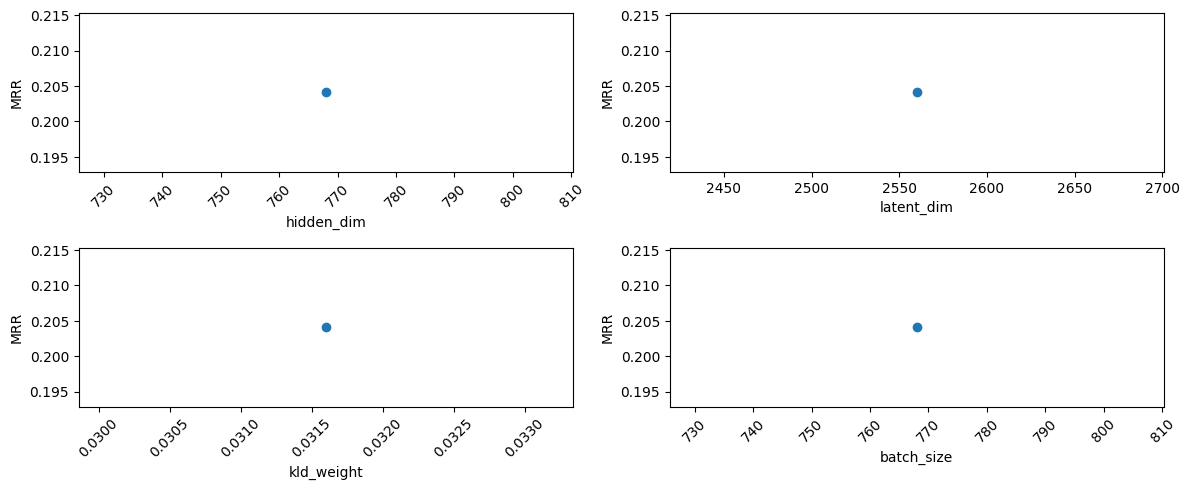

In [40]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12, 5))

ax[0][0].scatter(df['params_hidden_dim'], df['value'])
ax[0][0].set_xlabel('hidden_dim')
ax[0][0].set_ylabel('MRR')
ax[0][0].tick_params(axis='x', rotation=45)

ax[0][1].scatter(df['params_latent_dim'], df['value'])
ax[0][1].set_xlabel('latent_dim')
ax[0][1].set_ylabel('MRR')

ax[1][0].scatter(df['params_kld_weight'], df['value'])
ax[1][0].set_xlabel('kld_weight')
ax[1][0].set_ylabel('MRR')
ax[1][0].tick_params(axis='x', rotation=45)

ax[1][1].scatter(df['params_batch_size'], df['value'])
ax[1][1].set_xlabel('batch_size')
ax[1][1].set_ylabel('MRR')
ax[1][1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()